# Hito 3: Estimación de errores de soluciones numéricas

En este ntb:
1. Extrapolación de Richardson para estimar errores
2. Diferentes esquemas temporales
3. Análisis de tasas de convergencia

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## 1. Extrapolación de Richardson

Función para estimar el error de integración numérica mediante extrapolación de Richardson.

In [41]:
def richardson_extrapolation(U1, U2, p, m=2):
    """
    Extrapola el error usando Richardson
    
    Args:
        U1: Solución con paso h
        U2: Solución con paso h/m
        p: Orden del método
        m: Factor de refinamiento
    
    Returns:
        Error estimado y solución mejorada
    """
    error = (U2 - U1) / (m**p - 1)
    U_improved = U2 + error
    
    return error, U_improved

## 2. Esquemas temporales

Implementación de diferentes métodos numéricos para problemas de Cauchy.

In [42]:
def euler(F, U, dt, t):
    """Método de Euler explícito"""
    return U + dt * F(U, t)

def euler_inverso(F, U, dt, t):
    """Método de Euler implícito"""
    def residual(U_new):
        return U_new - U - dt * F(U_new, t + dt)
    
    # Resolver con fsolve (mejor para sistemas)
    U_new = fsolve(residual, U)
    return U_new

def crank_nicolson(F, U, dt, t):
    """Método de Crank-Nicolson"""
    def residual(U_new):
        return U_new - U - dt/2 * (F(U, t) + F(U_new, t + dt))
    
    U_new = fsolve(residual, U)
    return U_new

def runge_kutta_4(F, U, dt, t):
    """Método de Runge-Kutta de orden 4"""
    k1 = F(U, t)
    k2 = F(U + dt/2 * k1, t + dt/2)
    k3 = F(U + dt/2 * k2, t + dt/2)
    k4 = F(U + dt * k3, t + dt)
    
    return U + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

## 3. Función para integración temporal

Función general que integra usando cualquier esquema temporal.

In [43]:
def cauchy_problem(F, U0, t_span, dt, scheme):
    """
    Resuelve problema de Cauchy con esquema dado
    
    Args:
        F: Función F(U,t)
        U0: Condición inicial
        t_span: [t0, tf] intervalo temporal
        dt: Paso temporal
        scheme: Función del esquema temporal
    
    Returns:
        t: Vector de tiempos
        U: Solución en cada tiempo
    """
    t0, tf = t_span
    N = int((tf - t0) / dt)
    t = np.linspace(t0, tf, N+1)
    
    # Inicializar solución (asegurar formato array)
    U0 = np.atleast_1d(U0)
    U = np.zeros((N+1, len(U0)))
    U[0] = U0
    
    # Integrar
    for n in range(N):
        U[n+1] = scheme(F, U[n], dt, t[n])
    
    return t, U

## 4. Función para calcular tasa de convergencia

Evalúa el orden de convergencia de un esquema temporal.

In [44]:
def convergence_rate(F, U0, t_span, scheme, dt_values, U_exact=None):
    """
    Calcula la tasa de convergencia de un esquema
    
    Args:
        F: Función del problema
        U0: Condición inicial
        t_span: Intervalo temporal
        scheme: Esquema temporal
        dt_values: Lista de pasos temporales
        U_exact: Solución exacta (opcional)
    
    Returns:
        errors: Errores para cada dt
        rates: Tasas de convergencia
    """
    errors = []
    
    for dt in dt_values:
        t, U = cauchy_problem(F, U0, t_span, dt, scheme)
        
        if U_exact is not None:
            # Error con solución exacta
            error = np.linalg.norm(U[-1] - U_exact(t[-1]))
        else:
            # Error por Richardson (comparar con dt/2)
            dt_refined = dt / 2
            t_ref, U_ref = cauchy_problem(F, U0, t_span, dt_refined, scheme)
            
            # Interpolar para comparar en mismo punto
            error = np.linalg.norm(U[-1] - U_ref[-1])
        
        errors.append(error)
    
    # Calcular tasas de convergencia
    errors = np.array(errors)
    rates = []
    
    for i in range(len(errors)-1):
        rate = np.log(errors[i] / errors[i+1]) / np.log(dt_values[i] / dt_values[i+1])
        rates.append(rate)
    
    return errors, rates

## 5. Ejemplo: Oscilador armónico

Aplicación a un problema de prueba con solución conocida.

In [45]:
# Definir problema: oscilador armónico
# U' = [v, -omega^2 * x]
omega = 1.0

def F_oscillator(U, t):
    """Oscilador armónico: x'' + omega^2 * x = 0"""
    x, v = U
    return np.array([v, -omega**2 * x])

# Condición inicial
U0 = np.array([1.0, 0.0])  # [x0, v0]

# Solución exacta
def U_exact(t):
    return np.array([np.cos(omega * t), -omega * np.sin(omega * t)])

# Intervalo temporal
t_span = [0, 2*np.pi]

## 6. Comparación de esquemas temporales

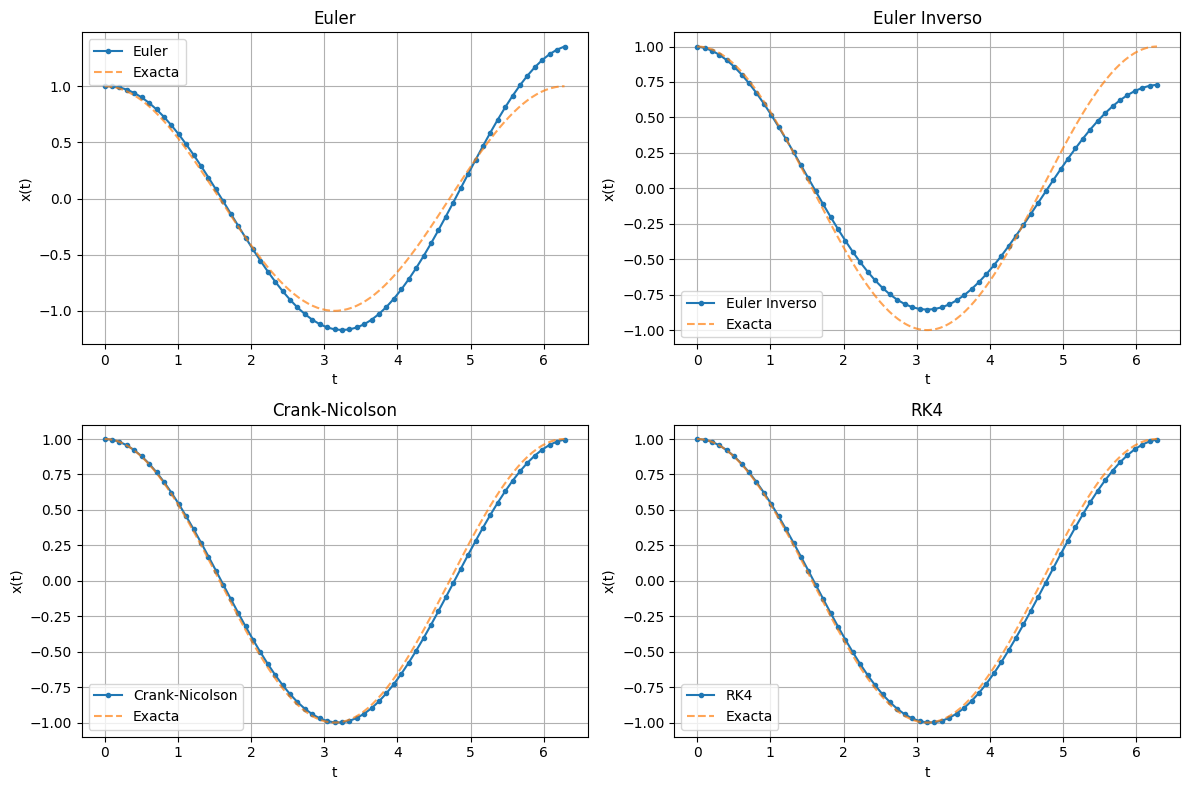

In [46]:
# Pasos temporales para análisis
dt_test = 0.1

# Resolver con diferentes esquemas
schemes = {
    'Euler': euler,
    'Euler Inverso': euler_inverso,
    'Crank-Nicolson': crank_nicolson,
    'RK4': runge_kutta_4
}

plt.figure(figsize=(12, 8))

for i, (name, scheme) in enumerate(schemes.items(), 1):
    t, U = cauchy_problem(F_oscillator, U0, t_span, dt_test, scheme)
    
    plt.subplot(2, 2, i)
    plt.plot(t, U[:, 0], 'o-', label=f'{name}', markersize=3)
    
    # Solución exacta
    t_exact = np.linspace(t_span[0], t_span[1], 200)
    U_ex = np.array([U_exact(ti)[0] for ti in t_exact])
    plt.plot(t_exact, U_ex, '--', label='Exacta', alpha=0.7)
    
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.title(name)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Análisis de convergencia

In [47]:
# Rango de pasos temporales
dt_values = np.array([0.4, 0.2, 0.1, 0.05, 0.025])

# Calcular convergencia para cada esquema
convergence_results = {}

for name, scheme in schemes.items():
    errors, rates = convergence_rate(
        F_oscillator, U0, t_span, scheme, dt_values, U_exact
    )
    convergence_results[name] = {'errors': errors, 'rates': rates}
    
    print(f"\n{name}:")
    print(f"  Errores: {errors}")
    print(f"  Tasas de convergencia: {rates}")
    print(f"  Orden medio: {np.mean(rates):.2f}")


Euler:
  Errores: [2.27125201 0.86553776 0.38104042 0.17391412 0.08216442]
  Tasas de convergencia: [np.float64(1.3918191292120474), np.float64(1.1836526950654882), np.float64(1.131569027411222), np.float64(1.0817893440435788)]
  Orden medio: 1.20

Euler Inverso:
  Errores: [0.74615732 0.47126942 0.27990359 0.14878563 0.07596778]
  Tasas de convergencia: [np.float64(0.6629277787443882), np.float64(0.7516220876759641), np.float64(0.9116947376342762), np.float64(0.9697755955936166)]
  Orden medio: 0.82

Crank-Nicolson:
  Errores: [0.35935628 0.10368236 0.08831551 0.03448519 0.00851207]
  Tasas de convergencia: [np.float64(1.7932444952858884), np.float64(0.23143164393430465), np.float64(1.3566897880849946), np.float64(2.01839450154054)]
  Orden medio: 1.35

RK4:
  Errores: [0.28337658 0.08324217 0.08316645 0.03318411 0.0081853 ]
  Tasas de convergencia: [np.float64(1.7673339921280797), np.float64(0.0013129738580509318), np.float64(1.3255091080556431), np.float64(2.019384520163878)]
  Ord

## 8. Gráfica de convergencia

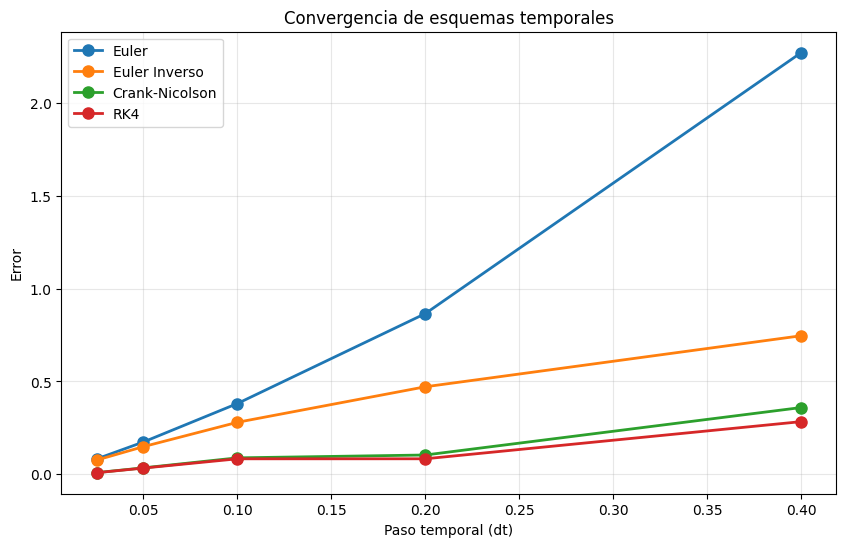

In [48]:
plt.figure(figsize=(10, 6))

# Graficar en escala normal
for name, results in convergence_results.items():
    plt.plot(dt_values, results['errors'], 'o-', label=name, linewidth=2, markersize=8)

plt.xlabel('Paso temporal (dt)')
plt.ylabel('Error')
plt.title('Convergencia de esquemas temporales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Evolución temporal del error

Análisis de cómo evoluciona el error a lo largo del tiempo para cada esquema.

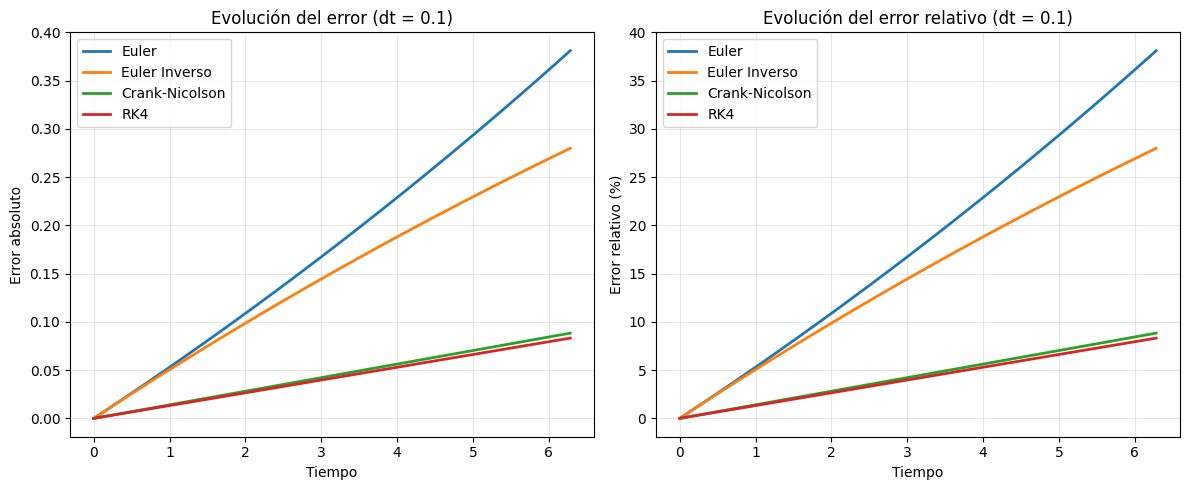

In [49]:
# Paso temporal fijo para el análisis
dt_fixed = 0.1

plt.figure(figsize=(12, 5))

# Error absoluto en posición
plt.subplot(1, 2, 1)
for name, scheme in schemes.items():
    t, U = cauchy_problem(F_oscillator, U0, t_span, dt_fixed, scheme)
    
    # Calcular error en cada instante
    errors_time = np.zeros(len(t))
    for i, ti in enumerate(t):
        U_ex = U_exact(ti)
        errors_time[i] = np.linalg.norm(U[i] - U_ex)
    
    plt.plot(t, errors_time, label=name, linewidth=2)

plt.xlabel('Tiempo')
plt.ylabel('Error absoluto')
plt.title(f'Evolución del error (dt = {dt_fixed})')
plt.legend()
plt.grid(True, alpha=0.3)

# Error relativo en posición
plt.subplot(1, 2, 2)
for name, scheme in schemes.items():
    t, U = cauchy_problem(F_oscillator, U0, t_span, dt_fixed, scheme)
    
    # Calcular error relativo en cada instante
    errors_rel = np.zeros(len(t))
    for i, ti in enumerate(t):
        U_ex = U_exact(ti)
        errors_rel[i] = np.linalg.norm(U[i] - U_ex) / (np.linalg.norm(U_ex) + 1e-10)
    
    plt.plot(t, errors_rel * 100, label=name, linewidth=2)

plt.xlabel('Tiempo')
plt.ylabel('Error relativo (%)')
plt.title(f'Evolución del error relativo (dt = {dt_fixed})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Extrapolación de Richardson aplicada

Ejemplo de mejora de solución mediante Richardson.

In [50]:
# Comparar solución con y sin Richardson
dt_coarse = 0.2
dt_fine = 0.1

# Euler (orden p=1)
t1, U1 = cauchy_problem(F_oscillator, U0, t_span, dt_coarse, euler)
t2, U2 = cauchy_problem(F_oscillator, U0, t_span, dt_fine, euler)

# Aplicar Richardson
error_est, U_improved = richardson_extrapolation(U1[-1], U2[-1], p=1, m=2)

print(f"\nExtrapolación de Richardson (Euler):")
print(f"  U con dt={dt_coarse}: {U1[-1]}")
print(f"  U con dt={dt_fine}: {U2[-1]}")
print(f"  Error estimado: {error_est}")
print(f"  U mejorada: {U_improved}")
print(f"  U exacta: {U_exact(t_span[1])}")
print(f"  Error real mejorado: {np.linalg.norm(U_improved - U_exact(t_span[1]))}")


Extrapolación de Richardson (Euler):
  U con dt=0.2: [1.8119889  0.29971592]
  U con dt=0.1: [1.35401025 0.14095584]
  Error estimado: [-0.45797865 -0.15876008]
  U mejorada: [ 0.8960316  -0.01780424]
  U exacta: [1.0000000e+00 2.4492936e-16]
  Error real mejorado: 0.10548184673199308
